In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!curl https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/monet2photo.zip -o monet2photo.zip
!unzip -q monet2photo.zip

In [ ]:
import numpy as np
import os

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

trainA = []
trainB = []
testA = []
testB = []
for f in os.listdir('monet2photo/trainA'):
  trainA.append(mpimg.imread('monet2photo/trainA/' + f).transpose((2, 0, 1)))
for f in os.listdir('monet2photo/trainB'):
  trainB.append(mpimg.imread('monet2photo/trainB/' + f).transpose((2, 0, 1)))
for f in os.listdir('monet2photo/testA'):
  testA.append(mpimg.imread('monet2photo/testA/' + f).transpose((2, 0, 1)))
for f in os.listdir('monet2photo/testB'):
  testB.append(mpimg.imread('monet2photo/testB/' + f).transpose((2, 0, 1)))

In [ ]:
trainA[0].shape

In [ ]:
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, InstanceNorm2d, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, Dropout, ConvTranspose2d, LeakyReLU, Sigmoid
from torch.optim import Adam, SGD

if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"
print(dev)

In [ ]:
class Resblock(Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.conv2 = Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
      
    def forward(self, x):
        residual = x
        out = torch.nn.functional.relu(self.conv1(x))
        out = torch.nn.functional.relu(self.conv2(out))
        
        out += residual
        
        return out

In [ ]:
generator1 = Sequential(
# c7s1-64
Conv2d(3, 64, kernel_size=7, stride=1, padding=3),
InstanceNorm2d(64),
ReLU(inplace=True),
# d128
Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
InstanceNorm2d(128),
ReLU(inplace=True),
# d256
Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
InstanceNorm2d(256),
ReLU(inplace=True),
# R256 * 9
Resblock(),
Resblock(),
Resblock(),
Resblock(),
Resblock(),
Resblock(),
Resblock(),
Resblock(),
Resblock(),
# u128
ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
# u64
ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
# c7s1-3
Conv2d(64, 3, kernel_size=7, stride=1, padding=3),
Sigmoid()
).to(dev)

generator2 = Sequential(
# c7s1-64
Conv2d(3, 64, kernel_size=7, stride=1, padding=3),
InstanceNorm2d(64),
ReLU(inplace=True),
# d128
Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
InstanceNorm2d(128),
ReLU(inplace=True),
# d256
Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
InstanceNorm2d(256),
ReLU(inplace=True),
# R256 * 9
Resblock(),
Resblock(),
Resblock(),
Resblock(),
Resblock(),
Resblock(),
Resblock(),
Resblock(),
Resblock(),
# u128
ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
# u64
ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
# c7s1-3
Conv2d(64, 3, kernel_size=7, stride=1, padding=3),
Sigmoid()
).to(dev)

In [ ]:
discriminator1 = Sequential(
# c64
Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
InstanceNorm2d(64),
LeakyReLU(0.2, inplace=True),
# c128
Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
InstanceNorm2d(128),
LeakyReLU(0.2, inplace=True),
# c256
Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
InstanceNorm2d(256),
LeakyReLU(0.2, inplace=True),
# c512
Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
InstanceNorm2d(512),
LeakyReLU(0.2, inplace=True),
Conv2d(512, 1, kernel_size=16),
Sigmoid()
).to(dev)

discriminator2 = Sequential(
# c64
Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
InstanceNorm2d(64),
LeakyReLU(0.2, inplace=True),
# c128
Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
InstanceNorm2d(128),
LeakyReLU(0.2, inplace=True),
# c256
Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
InstanceNorm2d(256),
LeakyReLU(0.2, inplace=True),
# c512
Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
InstanceNorm2d(512),
LeakyReLU(0.2, inplace=True),
Conv2d(512, 1, kernel_size=16),
Sigmoid()
).to(dev)

In [10]:
trainA = np.array(trainA) 
trainB = np.array(trainB)
testA = np.array(testA)
testB = np.array(testB)

In [11]:
trainA.shape

(1072, 3, 256, 256)

In [12]:
num_training = min(trainA.shape[0], trainB.shape[0])

dis_optimizer = Adam(list(discriminator1.parameters()) + list(discriminator2.parameters()), lr=0.00001)
gen_optimizer = Adam(list(generator1.parameters()) + list(generator2.parameters()), lr=0.00001)

In [13]:
epoch = 10
for e in range(epoch):
  indicesA = np.arange(trainA.shape[0])
  indicesB = np.arange(trainB.shape[0])
  np.random.shuffle(indicesA)
  np.random.shuffle(indicesB)
  for iter in range(num_training):
    x = torch.Tensor(trainA[indicesA[iter]] / 255).to(dev).unsqueeze(0)
    y = torch.Tensor(trainB[indicesB[iter]] / 255).to(dev).unsqueeze(0)
    cyclex = generator2(generator1(x))
    cycley = generator1(generator2(y))
    cycleLoss = torch.mean(torch.abs(cyclex - x) + torch.abs(cycley - y))
    GANLoss1 = torch.log(discriminator2(y) + 1e-5) + torch.log(1 - discriminator2(generator1(x)) + 1e-5)
    GANLoss2 = torch.log(discriminator1(x) + 1e-5) + torch.log(1 - discriminator1(generator2(y)) + 1e-5)
    dis_optimizer.zero_grad()
    gen_optimizer.zero_grad()
    dis_loss = -torch.mean(GANLoss1 + GANLoss2)
    gen_loss = torch.mean(GANLoss1 + GANLoss2) + 10 * cycleLoss
    dis_loss.backward(retain_graph=True)
    gen_loss.backward()
    dis_optimizer.step()
    gen_optimizer.step()
    print('\r{} {} {}'.format(iter, dis_loss, gen_loss), end='')
  print('\nEpoch {} done.'.format(e))


1071 2.7082090377807617 -0.1015615463256836
Epoch 0 done.
1071 3.1291208267211914 -1.4694390296936035
Epoch 1 done.
1071 2.7734150886535645 -1.2495967149734497
Epoch 2 done.
1071 2.595508575439453 -0.7393200397491455
Epoch 3 done.
1071 3.0009546279907227 -1.461897611618042
Epoch 4 done.
1071 3.9122207164764404 -2.4364566802978516
Epoch 5 done.
1071 2.4915027618408203 -0.6804805994033813
Epoch 6 done.
1071 2.3753104209899902 -0.3768472671508789
Epoch 7 done.
1071 3.1704492568969727 -1.7513096332550049
Epoch 8 done.
1071 2.4608354568481445 -0.7282662391662598
Epoch 9 done.


In [14]:
model_save_name = 'generator1.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(generator1.state_dict(), path)

model_save_name = 'generator2.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(generator2.state_dict(), path)

model_save_name = 'discriminator1.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(discriminator1.state_dict(), path)

model_save_name = 'discriminator2.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(discriminator2.state_dict(), path)

In [15]:
generator1.load_state_dict(torch.load('/content/gdrive/My Drive/generator1.pt'))
generator2.load_state_dict(torch.load('/content/gdrive/My Drive/generator2.pt'))
discriminator1.load_state_dict(torch.load('/content/gdrive/My Drive/discriminator1.pt'))
discriminator2.load_state_dict(torch.load('/content/gdrive/My Drive/discriminator2.pt'))

<All keys matched successfully>

In [16]:
import matplotlib.pyplot as plt

def a2b(a):
  b = generator1(torch.Tensor(a).unsqueeze(0).to(dev)).detach().cpu().numpy()
  a = a.transpose(1, 2, 0)
  b = b[0].transpose(1, 2, 0)
  plt.imshow(a)
  plt.show()
  plt.imshow(b)
  plt.show()  

def b2a(b):
  a = generator2(torch.Tensor(b).unsqueeze(0).to(dev)).detach().cpu().numpy()
  b = b.transpose(1, 2, 0)
  a = a[0].transpose(1, 2, 0)
  plt.imshow(b)
  plt.show()
  plt.imshow(a)
  plt.show()  

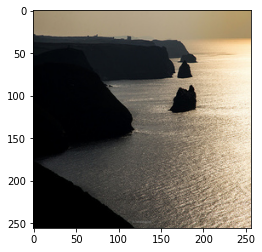

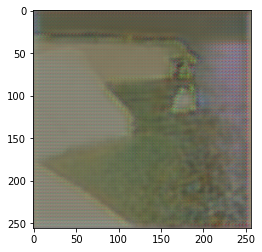

In [17]:
b2a(testB[0])

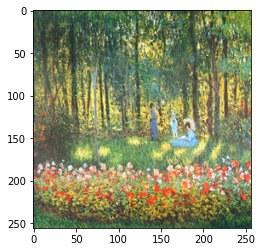

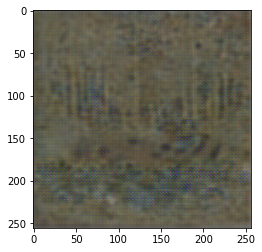

In [18]:
a2b(testA[0])